In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import json
import os

from tvb_inversion.base.diagnostics import (zscore, shrinkage)

In [43]:
# run_id = "2023-01-13_2028"  # around ground truth
# run_id = "2023-01-17_1206"  # around ground truth
# run_id = "2023-01-25_1618"  # around ground truth
# run_id = "2023-01-31_1233"  # around ground truth
# run_id = "2023-01-31_1906"  # around ground truth
# run_id = "2023-02-02_1238"  # around ground truth
# run_id = "2023-02-02_1319"  # around ground truth
run_id = ""

posterior_samples = np.load(f"sbi_data/posterior_samples_{run_id}.npy")
prior_samples = np.load(f"sbi_data/prior_samples_{run_id}.npy")
X = np.load(f"sbi_data/simulation_{run_id}.npy")
training_sims = np.load(f"sbi_data/training_sims_{run_id}.npy")
test_sims = np.load(f"sbi_data/test_sims_{run_id}.npy")
with open(f"sbi_data/sim_params_{run_id}.json", "r") as f:
    simulation_params = json.load(f)
with open(f"sbi_data/inference_params_{run_id}.json", "r") as f:
    inference_params = json.load(f)
with open(f"sbi_data/summary_{run_id}.json", "r") as f:
    summary = json.load(f)

In [44]:
inference_params

{'model_a': 1.5, 'nsig': 0.0001}

In [45]:
training_sims.shape, test_sims.shape

((4000, 250), (1000, 250))

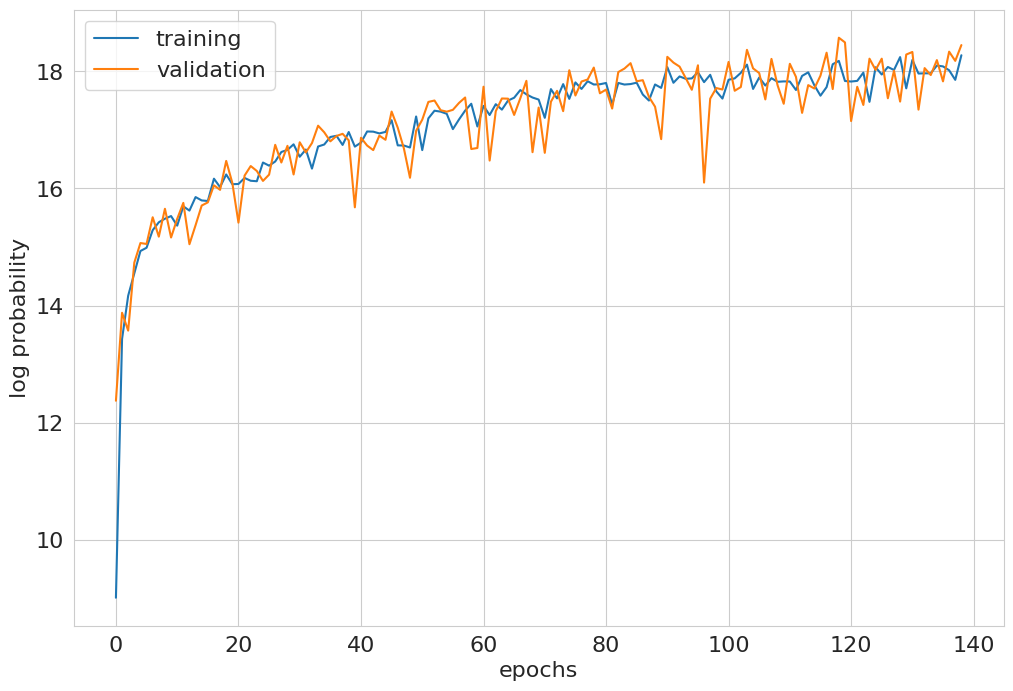

In [46]:
f1 = plt.figure(figsize=(12, 8))
plt.plot(summary["training_log_probs"], label="training")
plt.plot(summary["validation_log_probs"], label="validation")
plt.xlabel("epochs", size=16)
plt.ylabel("log probability", size=16)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16)
plt.show()

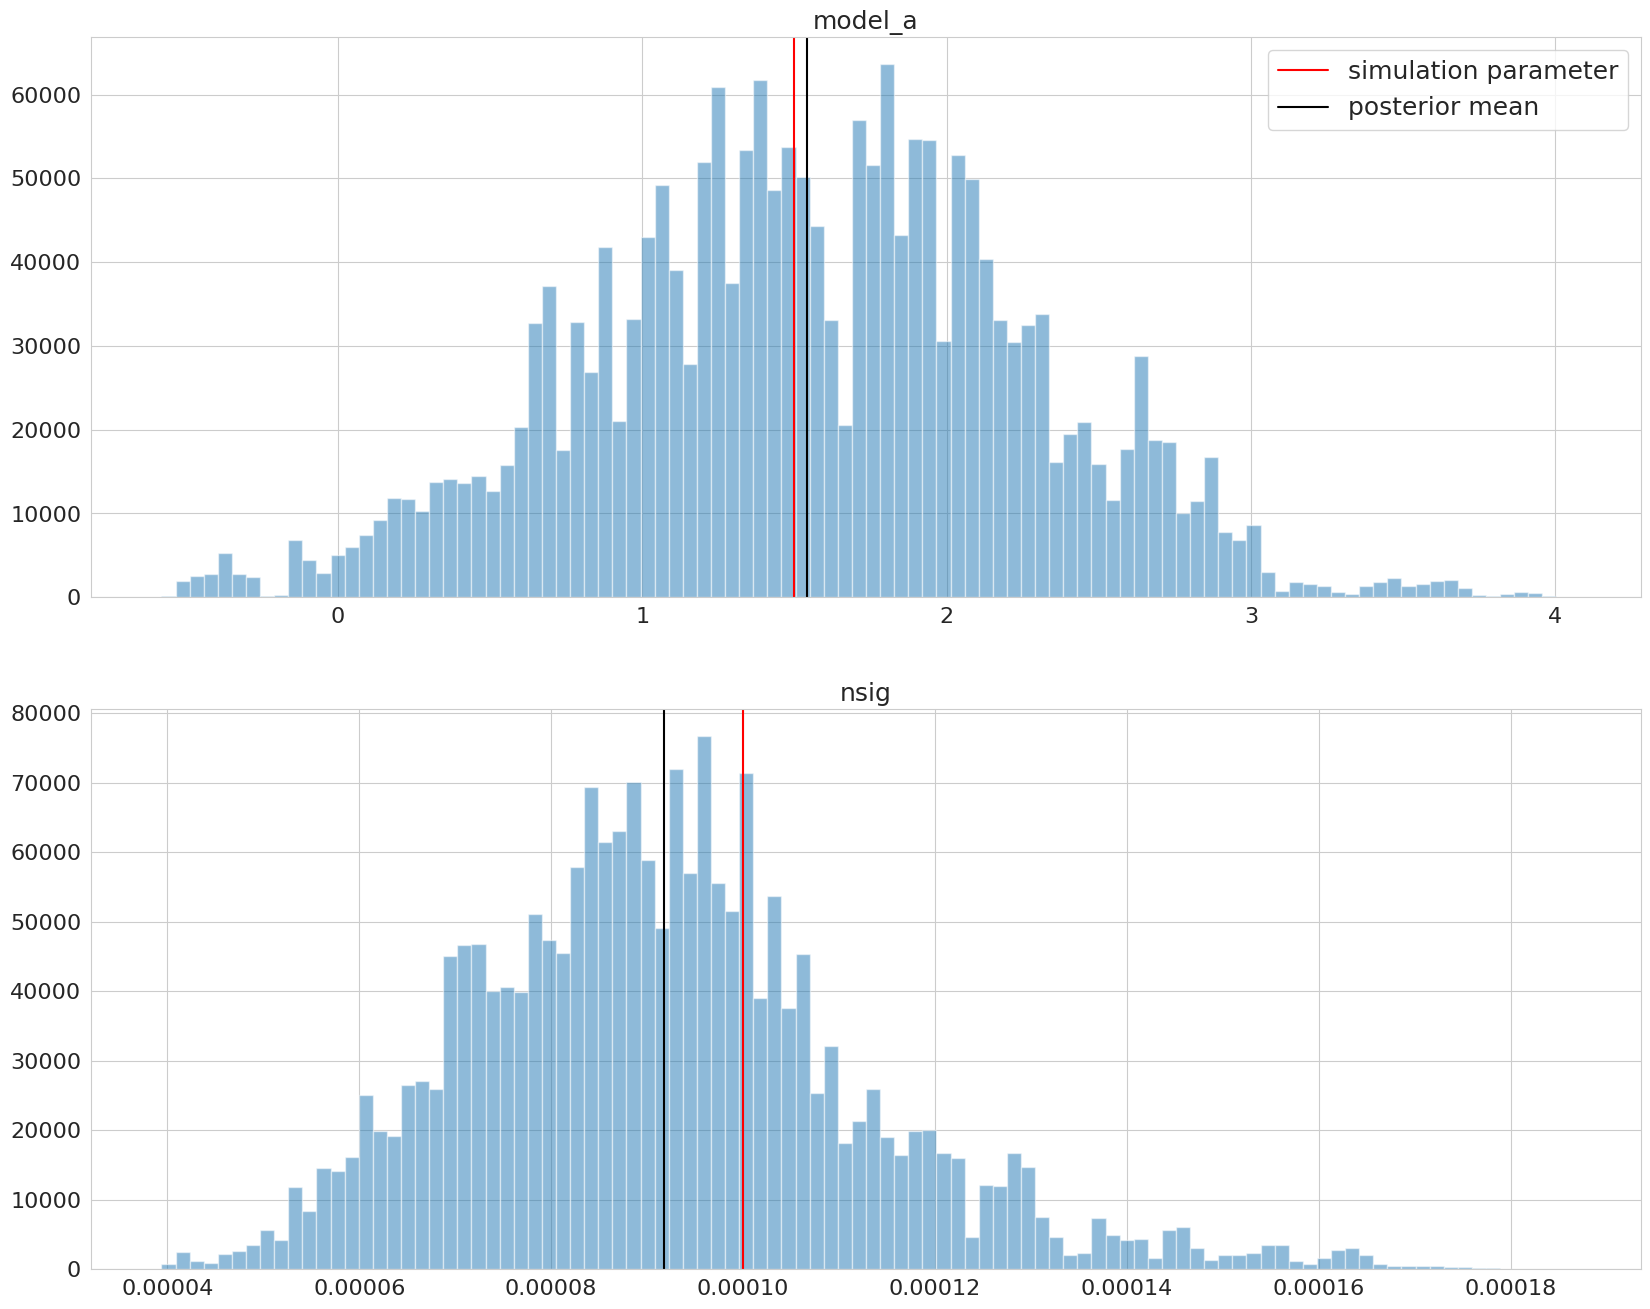

In [47]:
num_params = len(inference_params)
nrows = int(np.ceil(np.sqrt(num_params)))
ncols = int(np.ceil(num_params / nrows))

fig1, axes1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))
for ax in axes1.reshape(-1):
    ax.set_axis_off()
for i, (key, value) in enumerate(inference_params.items()):
    posterior_ = posterior_samples[:, :, i]
    posterior_ = posterior_.flatten()
    ax = axes1.reshape(-1)[i]
    ax.set_axis_on()
    ax.hist(posterior_, bins=100, alpha=0.5)
    ax.axvline(simulation_params[key], color="r", label="simulation parameter")
    ax.axvline(posterior_.mean(), color="k", label="posterior mean")
    # ax.axvline(prior_samples[:, i].mean(), color="k", linestyle="-.", label="prior mean")

    ax.set_title(key, fontsize=18)
    ax.tick_params(axis="both", labelsize=16)
try:
    axes1[0, 0].legend(fontsize=18)
except IndexError:
    axes1[0].legend(fontsize=18)
plt.show()

In [48]:
true_mean = np.asarray([value for _, value in simulation_params.items()])
posterior_mean = posterior_samples.reshape((-1, *posterior_samples.shape[2:])).mean(axis=0)
posterior_std = posterior_samples.reshape((-1, *posterior_samples.shape[2:])).std(axis=0)
prior_std = prior_samples.std(axis=0)

In [49]:
posterior_mean

array([1.5427805e+00, 9.1789370e-05], dtype=float32)

In [50]:
zscores = zscore(true_mean, posterior_mean, posterior_std)
shrinkages = shrinkage(prior_std, posterior_std)

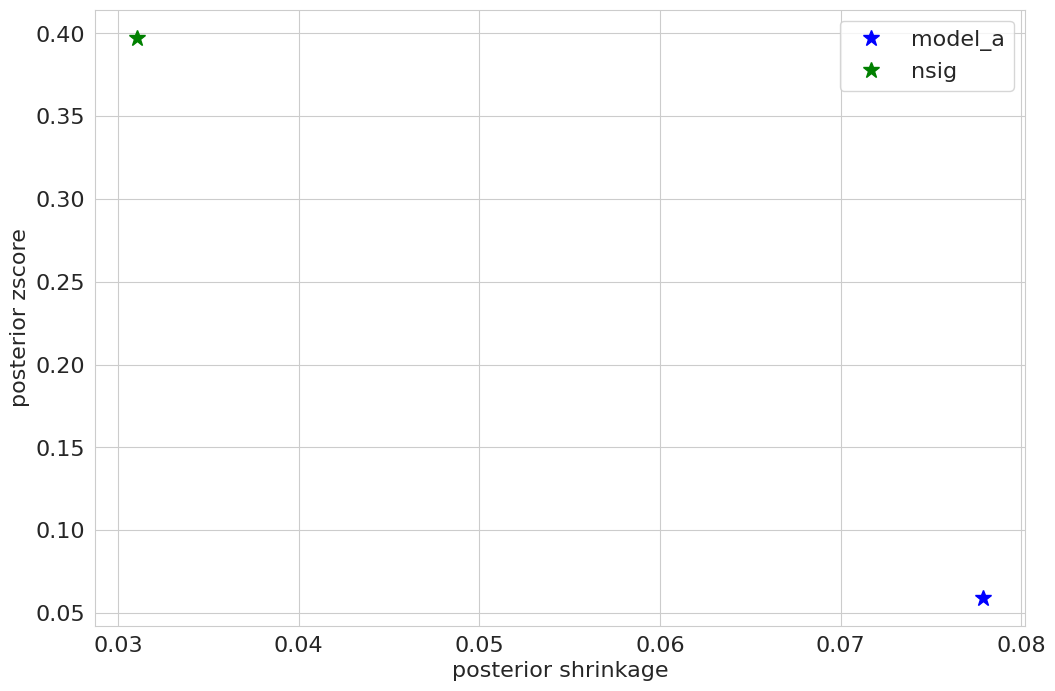

In [51]:
fig2 = plt.figure(figsize=(12,8))
plt.plot(shrinkages[0], zscores[0], color="blue", linewidth=0, marker="*", markersize=12, label="model_a")
plt.plot(shrinkages[1], zscores[1], color="green", linewidth=0, marker="*", markersize=12, label="nsig")
plt.xlabel("posterior shrinkage", size=16)
plt.ylabel("posterior zscore", size=16)
plt.legend(fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.show()

In [52]:
delete = True
if delete:
    os.remove(f"sbi_data/posterior_samples_{run_id}.npy")
    os.remove(f"sbi_data/prior_samples_{run_id}.npy")
    os.remove(f"sbi_data/simulation_{run_id}.npy")
    os.remove(f"sbi_data/training_sims_{run_id}.npy")
    os.remove(f"sbi_data/test_sims_{run_id}.npy")
    os.remove(f"sbi_data/sim_params_{run_id}.json")
    os.remove(f"sbi_data/inference_params_{run_id}.json")
    os.remove(f"sbi_data/summary_{run_id}.json")